# Identificação

**Assunto:** Modelagem

**Tutor:** Manoel Veríssimo dos Santos Neto e Matheus Patusco

## 1- Objetivos de Aprendizagem
Neste notebook, iremos:
1. Recuperar o dataset processado em CSV.
2. Comparar múltiplos algoritmos de machine learning.
3. Armazenar e versionar no MLflow o modelo com melhor desempenho e menor custo computacional.

### 1.1- Bibliotecas Necessárias
    

In [1]:
# Manipulação e visualização de dados
import pandas as pd
import seaborn as sns
import time

# Bibliotecas para aprendizado de máquina
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

# Inicialização do Dagshub com integração MLflow
import dagshub
dagshub.init(repo_owner='ahmiura', repo_name='my-first-repo', mlflow=True)

# MLflow para gerenciamento de experimentos
import mlflow
import mlflow.sklearn


# Supressão de avisos
import warnings
warnings.filterwarnings("ignore")

Accessing as ahmiura

Initialized MLflow to track repo "ahmiura/my-first-repo"

Repository ahmiura/my-first-repo initialized!

## 2- Recuperando o Dataset do MLflow

In [2]:
# Especificar o caminho do artefato no MLflow
artifact_path = "./dados/dados_processados.csv"

# Carregar o dataset processado
dados = pd.read_csv(artifact_path)
dados.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3- Dividindo os Dados para Treinamento e Teste

In [3]:
# Separando as features (X) e o target (y)
X = dados.drop(columns=["Survived", "Name", "Ticket", "Cabin", "Embarked"], errors='ignore')  # Substitua 'Survived' pelo nome da coluna alvo, se necessário
y = dados["Survived"]  # Substitua 'Survived' pelo nome da coluna alvo, se necessário

# Divisão dos dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Conjunto de treinamento: {X_train.shape}")
print(f"Conjunto de teste: {X_test.shape}")

print(f"\nTipos do treinamento: \n{X_train.dtypes}")
print(f"\nTipos do treinamento: \n{X_test.dtypes}")

Conjunto de treinamento: (712, 7)
Conjunto de teste: (179, 7)

Tipos do treinamento: 
PassengerId      int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
dtype: object

Tipos do treinamento: 
PassengerId      int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
dtype: object


4- Pré-processamento


Colunas categóricas encontradas: ['Sex']

Tipos do treinamento após One-Hot Encoding: 
PassengerId      int64
Pclass           int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Sex_male          bool
dtype: object

Tipos do teste após One-Hot Encoding: 
PassengerId      int64
Pclass           int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Sex_male          bool
dtype: object
Análise de Valores Ausentes para o DataFrame: Conjunto de Treinamento
     Valores Ausentes  % Ausente
Age               140  19.662921
Análise de Valores Ausentes para o DataFrame: Conjunto de Teste
     Valores Ausentes  % Ausente
Age                37  20.670391

Estatísticas Descritivas da Coluna 'Age' - Treinamento
count    572.000000
mean      29.498846
std       14.500059
min        0.420000
25%       21.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


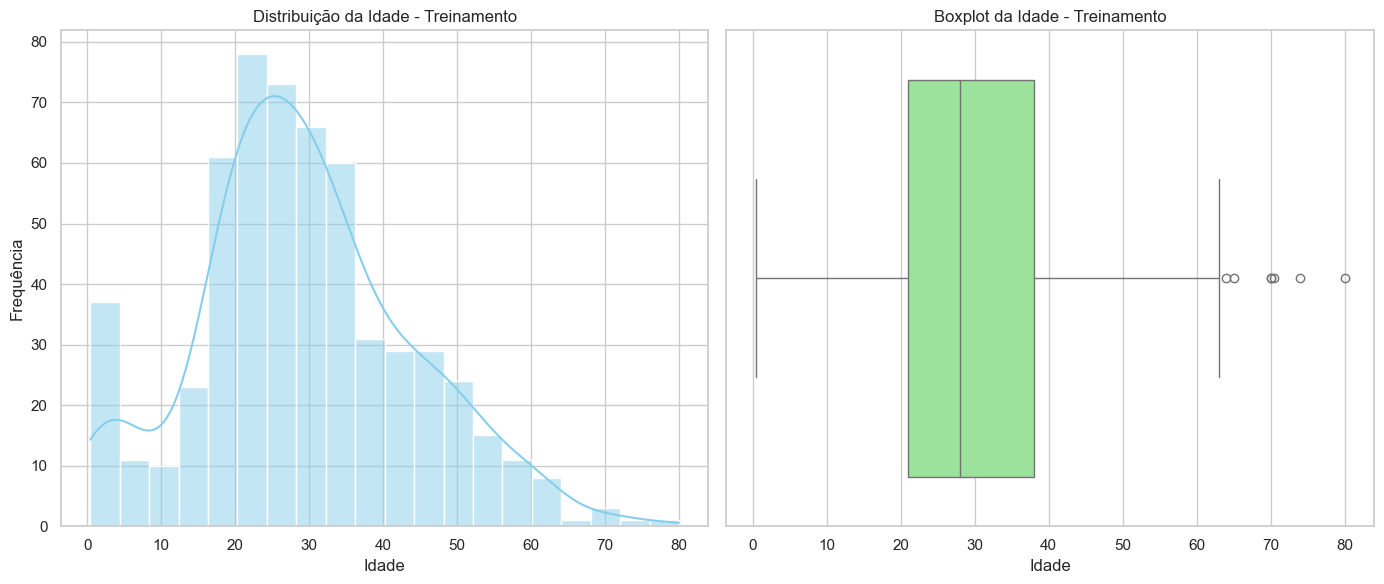

Análise de Valores Ausentes para o DataFrame: Conjunto de Treinamento após Imputação
Nenhum valor ausente encontrado.
Análise de Valores Ausentes para o DataFrame: Conjunto de Teste após Imputação
Nenhum valor ausente encontrado.


,Valores Ausentes,% Ausente


In [4]:
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Identificação de colunas categóricas
colunas_categoricas = X_train.select_dtypes(include=['object']).columns

if colunas_categoricas.empty:
    print("\nNenhuma coluna categórica encontrada.")
else:
    print(f"\nColunas categóricas encontradas: {list(colunas_categoricas)}")
    # One-Hot Encoding para variáveis categóricas
    X_train = pd.get_dummies(X_train, columns=colunas_categoricas, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=colunas_categoricas, drop_first=True)

print(f"\nTipos do treinamento após One-Hot Encoding: \n{X_train.dtypes}")
print(f"\nTipos do teste após One-Hot Encoding: \n{X_test.dtypes}")


# Função para analisar valores nulos em um DataFrame
def analisar_nulos(df, nome_df):
    """
    Analisa os valores nulos em um DataFrame e retorna um resumo.
    """
    # Calcula a contagem e a porcentagem de nulos
    contagem_nulos = df.isnull().sum()
    porcentagem_nulos = (contagem_nulos / len(df)) * 100
    
    # Cria um DataFrame para visualizar os resultados
    resumo_nulos = pd.DataFrame({
        'Valores Ausentes': contagem_nulos,
        '% Ausente': porcentagem_nulos
    })
    
    # Filtra apenas as colunas que de fato têm valores ausentes e ordena
    resumo_nulos = resumo_nulos[resumo_nulos['Valores Ausentes'] > 0].sort_values(by='% Ausente', ascending=False)
    
    print(f"Análise de Valores Ausentes para o DataFrame: {nome_df}")
    if resumo_nulos.empty:
        print("Nenhum valor ausente encontrado.")
    else:
        print(resumo_nulos)
        
    return resumo_nulos

# Analisando valores nulos nos conjuntos de treinamento e teste
analisar_nulos(X_train, "Conjunto de Treinamento")
analisar_nulos(X_test, "Conjunto de Teste")

# Estatísticas descritivas da coluna 'Age' no conjunto de treinamento
print("\nEstatísticas Descritivas da Coluna 'Age' - Treinamento")
print(X_train['Age'].describe())


# Configuração do estilo dos gráficos
sns.set(style="whitegrid")

# Criação de uma figura com dois subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histograma para a coluna 'Age' no conjunto de treinamento
sns.histplot(data=X_train, x='Age', kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribuição da Idade - Treinamento')
axes[0].set_xlabel('Idade')
axes[0].set_ylabel('Frequência')

# Boxplot para a coluna 'Age' no conjunto de treinamento
sns.boxplot(data=X_train, x='Age', ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot da Idade - Treinamento')
axes[1].set_xlabel('Idade')

# Mostra os gráficos
plt.tight_layout()
plt.show()


# Imputação de valores nulos com a mediana para variáveis numéricas
imputer = SimpleImputer(strategy='median')
X_train['Age'] = imputer.fit_transform(X_train[['Age']])
X_test['Age'] = imputer.transform(X_test[['Age']])


# Analisando valores nulos nos conjuntos de treinamento e teste
analisar_nulos(X_train, "Conjunto de Treinamento após Imputação")
analisar_nulos(X_test, "Conjunto de Teste após Imputação")


## 4- Comparando Algoritmos de Machine Learning

In [8]:
# Lista de modelos para comparar
modelos = {
    # --- Baselines ---
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),

    # --- Modelos Tunados v0---
    "RandomForest_tunado_v0": RandomForestClassifier(n_estimators=200, random_state=42),
    "LogisticRegression_tunado_v0": LogisticRegression(C=0.1, max_iter=10, random_state=42),
    "KNeighbors_tunado_v0": KNeighborsClassifier(n_neighbors=7),
    "GradientBoosting_tunado_v0": GradientBoostingClassifier(learning_rate=0.05, n_estimators=200, random_state=42),

    # --- Modelos Tunados v1---
    "RandomForest_tunado_v1": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "LogisticRegression_tunado_v1": LogisticRegression(C=0.1, solver='liblinear', random_state=42),
    "KNeighbors_tunado_v1": KNeighborsClassifier(n_neighbors=7, weights='distance'),
    "GradientBoosting_tunado_v1": GradientBoostingClassifier(learning_rate=0.05, n_estimators=200, max_depth=5, random_state=42),
    
    # --- Modelos Tunados v2---
    "RandomForest_tunado_v2": RandomForestClassifier(
        n_estimators=200, 
        max_depth=10, 
        min_samples_split=10,  # Experimente valores como 5, 10, 15
        min_samples_leaf=4,    # Experimente valores como 2, 4, 6
        random_state=42
    ),
    "LogisticRegression_tunado_v2": LogisticRegression(
        C=0.1, 
        solver='liblinear', 
        penalty='l1', 
        random_state=42
    ),
    "KNeighbors_tunado_v2": KNeighborsClassifier(
        n_neighbors=7, 
        weights='distance',
        metric='manhattan'  # Testar uma métrica de distância diferente
    ),
    "GradientBoosting_tunado_v2": GradientBoostingClassifier(
        learning_rate=0.05, 
        n_estimators=200, 
        max_depth=5,
        subsample=0.8,  # Adicionar o subsample para robustez
        random_state=42
    )
}

resultados = []

# Avaliar cada modelo
for nome, modelo in modelos.items():
    inicio = time.time()
    modelo.fit(X_train, y_train)  # Treinamento
    fim = time.time()

    # Previsões
    y_pred = modelo.predict(X_test)

    # Métricas
    acuracia = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    tempo_treino = fim - inicio

    # Registrar no MLflow
    with mlflow.start_run(run_name=nome):
        mlflow.log_param("Modelo", nome)
        mlflow.log_metric("Acurácia", acuracia)
        mlflow.log_metric("F1-Score", f1)
        mlflow.log_metric("Tempo de Treinamento", tempo_treino)
        mlflow.sklearn.log_model(modelo, "modelo")

    # Armazenar resultados
    resultados.append({
        "Modelo": nome,
        "Acurácia": acuracia,
        "F1-Score": f1,
        "Tempo de Treinamento (s)": tempo_treino
    })
    print(f"Modelo {nome} treinado e registrado no MLflow.")

2025/11/02 15:06:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/7e965569000f497a948b03d353b58217
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo Random Forest treinado e registrado no MLflow.


2025/11/02 15:06:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/3cb32cdefda34cb195253347ad26fcc3
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo Logistic Regression treinado e registrado no MLflow.


2025/11/02 15:07:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run K-Nearest Neighbors at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/5b58abaa832647489811d94545e0cef9
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo K-Nearest Neighbors treinado e registrado no MLflow.


2025/11/02 15:07:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Gradient Boosting at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/7606ac5e462e4fb0993134d297501dab
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo Gradient Boosting treinado e registrado no MLflow.


2025/11/02 15:07:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_tunado_v0 at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/85afe6856c734cd9ae819d469b6d86a9
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo RandomForest_tunado_v0 treinado e registrado no MLflow.


2025/11/02 15:07:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_tunado_v0 at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/075659c77b3846f1b9d7c8582826e3e3
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo LogisticRegression_tunado_v0 treinado e registrado no MLflow.


2025/11/02 15:08:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run KNeighbors_tunado_v0 at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/b93d881bd1c4474682a9699d63b82fbe
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo KNeighbors_tunado_v0 treinado e registrado no MLflow.


2025/11/02 15:08:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run GradientBoosting_tunado_v0 at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/5eff3fdd2df24735bd8c64d8e6c9bdd1
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo GradientBoosting_tunado_v0 treinado e registrado no MLflow.


2025/11/02 15:08:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_tunado_v1 at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/2011b30e59b740b88f308e518b3d061d
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo RandomForest_tunado_v1 treinado e registrado no MLflow.


2025/11/02 15:08:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_tunado_v1 at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/2d8597b52b484eaab1f14b6370046735
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo LogisticRegression_tunado_v1 treinado e registrado no MLflow.


2025/11/02 15:09:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run KNeighbors_tunado_v1 at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/98bce139c0a34e7ba58fbb2cd21d3d65
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo KNeighbors_tunado_v1 treinado e registrado no MLflow.


2025/11/02 15:09:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run GradientBoosting_tunado_v1 at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/e1bac188a1d04f438d8371f76a090e66
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo GradientBoosting_tunado_v1 treinado e registrado no MLflow.


2025/11/02 15:09:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_tunado_v2 at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/fa6c029279634c88a2bfc14484c0b972
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo RandomForest_tunado_v2 treinado e registrado no MLflow.


2025/11/02 15:09:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_tunado_v2 at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/05ff9754396e4fa0be9792348d8aeb7e
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo LogisticRegression_tunado_v2 treinado e registrado no MLflow.


2025/11/02 15:09:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run KNeighbors_tunado_v2 at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/981cfba59de148a3a659e43b20a3e09d
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo KNeighbors_tunado_v2 treinado e registrado no MLflow.


2025/11/02 15:10:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run GradientBoosting_tunado_v2 at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/ac85d171192541b58b599cbf141c0b84
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Modelo GradientBoosting_tunado_v2 treinado e registrado no MLflow.


## 5- Resultados da Comparação

In [9]:
# Criar um DataFrame com os resultados
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by=["Acurácia", "Tempo de Treinamento (s)"], ascending=[False, True], inplace=True)
print("Resultados da Comparação:")
print(df_resultados)

# Exibir o modelo com melhor desempenho
melhor_modelo = df_resultados.iloc[0]
print(f"Melhor Modelo: {melhor_modelo['Modelo']}")

Resultados da Comparação:
                          Modelo  Acurácia  F1-Score  Tempo de Treinamento (s)
8         RandomForest_tunado_v1  0.821229  0.818815                  0.393720
15    GradientBoosting_tunado_v2  0.821229  0.819402                  0.533728
7     GradientBoosting_tunado_v0  0.815642  0.812140                  0.328012
1            Logistic Regression  0.804469  0.802769                  0.051258
3              Gradient Boosting  0.804469  0.800754                  0.191050
4         RandomForest_tunado_v0  0.804469  0.803824                  0.386640
11    GradientBoosting_tunado_v1  0.804469  0.802157                  0.611926
0                  Random Forest  0.793296  0.792613                  0.292921
12        RandomForest_tunado_v2  0.787709  0.784081                  0.374469
13  LogisticRegression_tunado_v2  0.770950  0.768958                  0.004688
9   LogisticRegression_tunado_v1  0.765363  0.761353                  0.005974
6           KNeighbors_tun

## 6- Armazenando o Melhor Modelo no MLflow

In [10]:
# Recuperar o modelo com melhor desempenho
nome_melhor_modelo = melhor_modelo["Modelo"]
modelo_final = modelos[nome_melhor_modelo]

# Armazenar o modelo final no MLflow
with mlflow.start_run(run_name="Melhor Modelo"):
    mlflow.log_param("Modelo", nome_melhor_modelo)
    mlflow.log_metric("Acurácia", melhor_modelo["Acurácia"])
    mlflow.log_metric("F1-Score", melhor_modelo["F1-Score"])
    mlflow.log_metric("Tempo de Treinamento", melhor_modelo["Tempo de Treinamento (s)"])
    mlflow.sklearn.log_model(modelo_final, "melhor_modelo")
print(f"Melhor modelo ({nome_melhor_modelo}) armazenado com sucesso no MLflow.")

2025/11/02 15:10:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Melhor Modelo at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0/runs/eefdd8c6c1af4bdc9c373ccf1a4554a0
🧪 View experiment at: https://dagshub.com/ahmiura/my-first-repo.mlflow/#/experiments/0
Melhor modelo (RandomForest_tunado_v1) armazenado com sucesso no MLflow.


## 7- Exercícios


1.   Verificar a documentação dos modelos RandomForestClassifier, LogisticRegression, KNeighborsClassifier, GradientBoostingClassifier e altere ou inclua algum parâmetro dos modelos e compare os resultados com o baseline executado nesse notebook.
2.   Busque algum outro dataset no Kaggle para um problema de regressão e faça um novo treino. Lembre de modificar as métricas, ex.: MSE.
3.   Execute o MLFlow de maneira que se parar o container os dados não sejam perdidos, podendo salvar os dados ou no SQLite (default) ou outro banco de dados da sua escolha.

**Importante:**

*   Todas as alterações devem ser registradas no Mlflow (subir em container) para que seja possível realizar comparações entre os experimentos.

## Conclusão


Este notebook demonstrou como comparar múltiplos algoritmos de machine learning, avaliar seus desempenhos e armazenar o melhor modelo no MLflow.
O MLflow foi utilizado para rastrear e versionar os experimentos e os modelos de forma eficaz.
    